*Author:Razin Karimi*<br>
Learnings: UNet, Activaton functions, Segmentation


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [2]:
from tensorflow.keras import models,layers,datasets

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from keras import metrics
import keras
import os
import random
from tqdm import tqdm 
from zipfile import ZipFile
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class UNet:
    def __init__(self,input_shape_,activation_="relu"):
        self.input_shape=input_shape_
        self.activation=activation_
        
    def dice_coef(self,y_true,y_pred,smooth=100):
        y_true=tf.cast(y_true,tf.float32)
        y_pred=tf.cast(y_pred,tf.float32)
        
        y_true_f=K.flatten(y_true)
        y_pred_f=K.flatten(y_pred)
        
        intersection=K.sum(y_true_f*y_pred_f)
        
        dice=(2. *intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)
        return dice
    
    def dice_coef_loss(self,y_true,y_pred):
        return -self.dice_coef(y_true,y_pred)
    
    def iou(self,y_true,y_pred):
        y_true=tf.cast(y_true,tf.float32)
        y_pred=tf.cast(y_pred,tf.float32)
        
        def f(y_true,y_pred):
            intersection=(y_true*y_pred).sum()
            union=y_true.sum()+y_pred.sum()-intersection
            x=(intersection+1e-15)/(union+1e-15)
            x=x.astype(np.float32)
            return x
        
        return tf.numpy_function(f,[y_true,y_pred],tf.float32)
    
    def buildModel(self):

        kernel_initializer='he_uniform'
        inputs=tf.keras.Input(shape=self.input_shape)
        s=inputs
        #contraction
        c1=Conv2D(16,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(s)
        c1=Conv2D(16,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c1)
        m1=MaxPooling2D(2,2)(c1)
        m1=Dropout(0.25)(m1)
        
        c2=Conv2D(32,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(m1)
        c2=Conv2D(32,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c2)
        m2=MaxPooling2D(2,2)(c2)
        m2=Dropout(0.25)(m2)
        
        c3=Conv2D(64,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(m2)
        c3=Conv2D(64,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c3)
        m3=MaxPooling2D(2,2)(c3)
        m3=Dropout(0.25)(m3)
        
        
        c4=Conv2D(128,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(m3)
        c4=Conv2D(128,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c4)
        m4=MaxPooling2D(2,2)(c4)
        m4=Dropout(0.25)(m4)
        
        c5=Conv2D(256,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(m4)
        c5=Conv2D(256,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c5)
        m5=MaxPooling2D(2,2)(c5)
        m5=Dropout(0.25)(m5)
        
        #middle layer
        c6=Conv2D(512,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(m5)
        c6=Conv2D(512,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c6)
        
        
        #decontraction
        
        dc1=Conv2DTranspose(256,(2, 2), strides=(2, 2),padding='same')(c6)
        dc1=concatenate([dc1,c5])
        dc1=Dropout(0.25)(dc1)
        c7=Conv2D(256,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(dc1)
        c7=Conv2D(256,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c7)
        
        dc2=Conv2DTranspose(128,(2, 2), strides=(2, 2),padding='same')(c7)
        dc2=concatenate([dc2,c4])
        dc2=Dropout(0.25)(dc2)
        c8=Conv2D(128,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(dc2)
        c8=Conv2D(128,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c8)
        
        dc3=Conv2DTranspose(64,(2, 2), strides=(2, 2),padding='same')(c8)
        dc3=concatenate([dc3,c3])
        dc3=Dropout(0.25)(dc3)
        c9=Conv2D(64,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(dc3)
        c9=Conv2D(64,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c9)
        
        dc4=Conv2DTranspose(32,(2, 2), strides=(2, 2),padding='same')(c9)
        dc4=concatenate([dc4,c2])
        dc4=Dropout(0.25)(dc4)
        c10=Conv2D(32,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(dc4)
        c10=Conv2D(32,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c10)
        
        dc5=Conv2DTranspose(16,(2, 2), strides=(2, 2),padding='same')(c10)
        dc5=concatenate([dc5,c1])
        dc5=Dropout(0.25)(dc5)
        c11=Conv2D(16,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(dc5)
        c11=Conv2D(16,(3,3),activation=self.activation,kernel_initializer=kernel_initializer,padding='same')(c11)
        
        
        outputs=Conv2D(1,(1,1),activation="sigmoid")(c11)
        
        model=Model(inputs=[inputs],outputs=[outputs])
        model.summary()
        
        return model
    
    def CompileandSummarize(self,model_):
        model_.compile(optimizer=tf.keras.optimizers.Adam(),loss=self.dice_coef_loss,metrics=self.iou)
        
        
        
        
        
    
        

In [4]:
class MexicanReLU(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0, sigma=1.0, mu=0.0):
        super(MexicanReLU, self).__init__()
        self.alpha = tf.Variable(alpha, trainable=True)
        self.sigma = tf.Variable(sigma, trainable=True)
        self.mu = tf.Variable(mu, trainable=True)

    def call(self, inputs):
        relu = tf.nn.relu(inputs)
        gaussian = self.alpha * tf.exp(-tf.square(inputs - self.mu) / (2 * tf.square(self.sigma))) * (inputs - self.mu)
        return relu + gaussian

In [5]:
class Swish(tf.keras.layers.Layer):
    def __init__(self):
        super(Swish, self).__init__()

    def call(self, inputs):
        return inputs * tf.keras.backend.sigmoid(inputs)

In [6]:
class TrainableLeakyReLU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer=tf.initializers.constant(0.2), **kwargs):
        super(TrainableLeakyReLU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)
    
    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(), initializer=self.alpha_initializer, trainable=True, name="alpha")
        super(TrainableLeakyReLU, self).build(input_shape)
    
    def call(self, inputs):
        return tf.maximum(inputs, self.alpha * inputs)
    
    def get_config(self):
        config = super(TrainableLeakyReLU, self).get_config()
        config.update({"alpha_initializer": self.alpha_initializer})
        return config

In [7]:
class ISRU(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0, **kwargs):
        super(ISRU, self).__init__(**kwargs)
        self.alpha = tf.Variable(initial_value=alpha, trainable=True, name='alpha')

    def call(self, inputs):
        return inputs / tf.sqrt(1.0 + self.alpha * tf.square(inputs))

In [8]:
class Mish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs * tf.math.tanh(tf.math.softplus(inputs))

In [9]:
class gated_swish(tf.keras.layers.Layer):
    
    def __init__(self):
        super(gated_swish, self).__init__()

    def call(self, inputs):

        """
        Gated Swish activation function.
        """
        gate = tf.math.sigmoid(inputs)
        activation = tf.nn.swish(inputs)
        
        return gate * activation

In [10]:
class SeLU(tf.keras.layers.Layer):
    def __init__(self, alpha=1.6732632423543772848170429916717, scale=1.0507009873554804934193349852946, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.scale = scale

    def call(self, inputs):
        return self.scale * tf.where(inputs > 0.0, inputs, self.alpha * tf.exp(inputs) - self.alpha)

    def get_config(self):
        config = super().get_config()
        config.update({'alpha': self.alpha, 'scale': self.scale})
        return config

In [11]:
import tensorflow as tf

class LearnableSwish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LearnableSwish, self).__init__(**kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(shape=(1, ), initializer="ones", trainable=True)
        super(LearnableSwish, self).build(input_shape)

    def call(self, inputs):
        return tf.nn.swish(inputs * self.beta)

In [12]:
class SRS(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0, **kwargs):
        super(SRS, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        return tf.maximum(inputs, self.alpha * (tf.sigmoid(inputs) - 0.5))

In [13]:
class TanELU(tf.keras.layers.Layer):
    def __init__(self, alpha=1.0, **kwargs):
        super(TanELU, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        pos = tf.nn.relu(inputs)
        neg = self.alpha * (tf.exp(inputs) - 1)
        return tf.where(inputs > 0, tf.tanh(pos), tf.tanh(neg))

In [14]:
from timeit import default_timer as timer
class TimingCallback(keras.callbacks.Callback):
    def __init__(self,logs={}):
        self.logs=[]
        
        
    def on_epoch_begin(self,epoch,logs={}):
        self.starttime=timer()
        
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(timer()-self.starttime)
        
        
    
    


In [15]:
with ZipFile("../input/data-science-bowl-2018/stage1_train.zip","r") as zipref:
    zipref.extractall("./stage1_train")

with ZipFile("../input/data-science-bowl-2018/stage1_test.zip","r") as zipref:
    zipref.extractall("./stage1_test")

In [16]:
seed=42
np.random.seed=seed

Image_height=96
Image_width=96
Image_channels=3

Train_path='./stage1_train/'
Test_path='./stage1_test/'

In [17]:
train_ids=next(os.walk(Train_path))[1]
test_ids=next(os.walk(Test_path))[1]
train_ids[:5]

['29ea4f6eb4545f43868a9b40a60000426bf8dfd9d062546656a37bd2a2aaf9ec',
 '9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32',
 'd3ce382f190ee24729bd2e80684c11bef72bc9c733cdbbc19a17d2c1b2e775f7',
 '5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856',
 '2c61fdcb36fd1b2944895af6204279e9f6c164ba894198b40c8b7a3c9bf500ea']

In [18]:
X_train=np.zeros((len(train_ids),Image_height,Image_width,Image_channels),dtype=np.uint8)
y_train=np.zeros((len(train_ids),Image_height,Image_width,1),dtype=np.bool)
print('Resizing images and masks')

for n,filename in tqdm(enumerate(train_ids)):
    path=Train_path+filename
    img=imread(path+'/images/'+filename+'.png')[:,:,:Image_channels]
    img=resize(img,(Image_height,Image_width),mode='constant',preserve_range=True)
    X_train[n]=img
    mask=np.zeros((Image_height,Image_width,1),dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (Image_height,Image_width), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    y_train[n] = mask




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Resizing images and masks


0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
670it [05:47,  1.93it/s]


In [19]:
X_test = np.zeros((len(test_ids),Image_height , Image_width, Image_channels), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = Test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:Image_channels
                                                  ]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (Image_height, Image_width), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 40.57it/s]

Done!


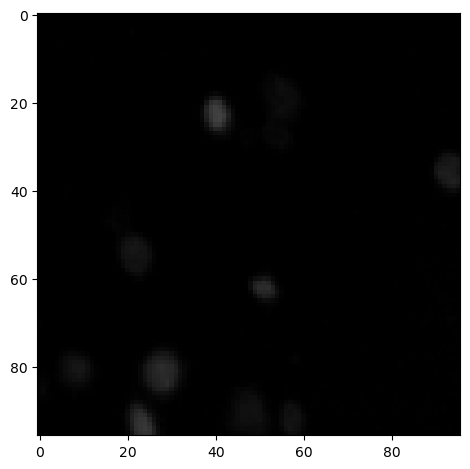

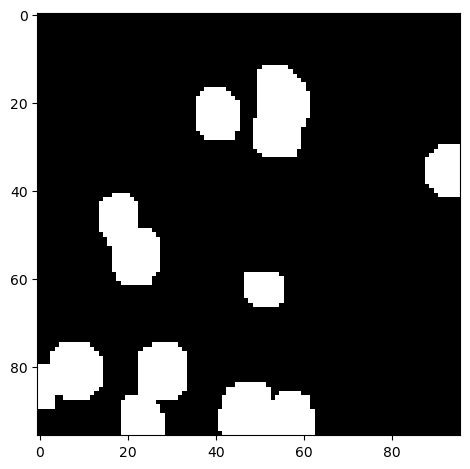

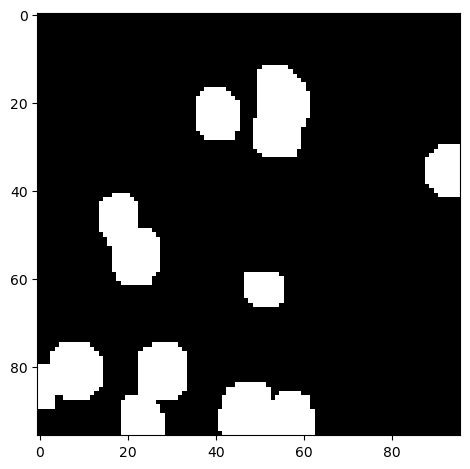

In [20]:
imshow(X_train[0])
plt.show()
imshow(y_train[0])
plt.show()
imshow(np.squeeze(y_train[0]))
plt.show()

In [21]:
X_test,y_test=X_train[536:],y_train[536:]
X_train,y_train=X_train[0:536],y_train[0:536]


In [22]:
(X_train.shape,y_train.shape),(X_test.shape,y_test.shape)


(((536, 96, 96, 3), (536, 96, 96, 1)), ((134, 96, 96, 3), (134, 96, 96, 1)))

In [23]:
!mkdir /kaggle/working/logs



In [24]:
tb_1 = tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/logs', profile_batch=(5, 8))


In [25]:
class GCU(tf.keras.layers.Layer):
    def __init__(self):
        super(GCU, self).__init__()
    
    def call(self, x):
        return tf.cast(tf.math.multiply(x , tf.math.cos(x))/tf.reduce_sum(x), tf.float32)

In [26]:
training_inferences={}


In [27]:
cb = TimingCallback()

UNet_1 = UNet((96, 96, 3), activation_= MexicanReLU())
model1 = UNet_1.buildModel()
UNet_1.CompileandSummarize(model1)
results1 = model1.fit(x = X_train, y = y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],  validation_data = (X_test, y_test))

training_inferences['MexicanReLU'] = sum(cb.logs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 16)   451         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 96, 16)   2323        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 48, 16)   0           ['conv2d_1[0][0]']               
                                                                                              

2023-06-03 13:35:58.356293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 25s 51ms/step - loss: -0.7329 - iou: 0.6001 - val_loss: -0.8661 - val_iou: 0.7655
Epoch 2/150
67/67 [==============================] - 2s 32ms/step - loss: -0.8926 - iou: 0.8078 - val_loss: -0.8830 - val_iou: 0.7920
Epoch 3/150
67/67 [==============================] - 2s 30ms/step - loss: -0.8957 - iou: 0.8133 - val_loss: -0.8969 - val_iou: 0.8142
Epoch 4/150
67/67 [==============================] - 2s 29ms/step - loss: -0.9039 - iou: 0.8264 - val_loss: -0.9066 - val_iou: 0.8302
Epoch 5/150
67/67 [==============================] - 2s 37ms/step - loss: -0.9084 - iou: 0.8351 - val_loss: -0.9154 - val_iou: 0.8450
Epoch 6/150
67/67 [==============================] - 2s 29ms/step - loss: -0.9030 - iou: 0.8250 - val_loss: -0.9108 - val_iou: 0.8375
Epoch 7/150
67/67 [==============================] - 2s 32ms/step - loss: -0.9170 - iou: 0.8475 - val_loss: -0.9168 - val_iou: 0.8475
Epoch 8/150
67/67 [==============================] - 2s 29ms/step - loss:

In [28]:
results1.history.keys()



dict_keys(['loss', 'iou', 'val_loss', 'val_iou'])

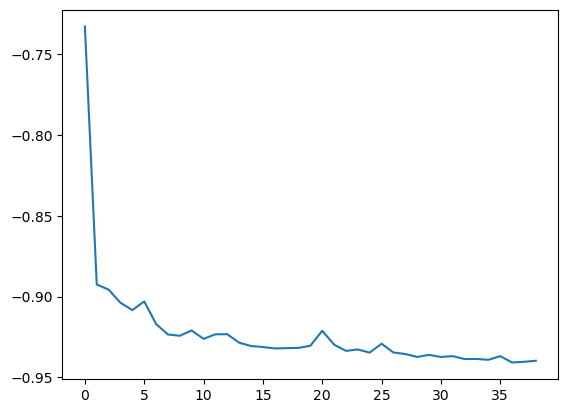

In [29]:
plt.plot(results1.history['loss'])

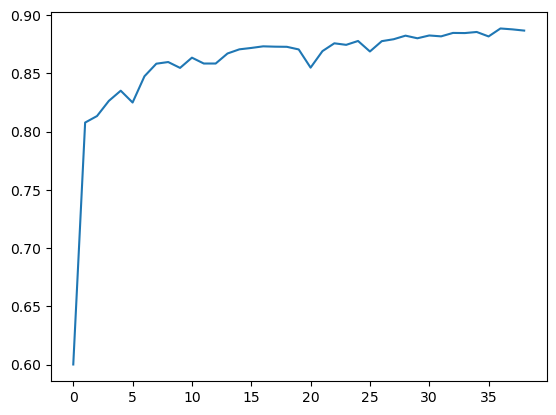

In [30]:
plt.plot(results1.history['iou'])

In [31]:
cb = TimingCallback()

UNet_2 = UNet((96, 96, 3), activation_= Swish())
model2 = UNet_2.buildModel()
UNet_2.CompileandSummarize(model2)
results2 = model2.fit(x = X_train, y = y_train, batch_size = 8, epochs=150, callbacks =  [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],  validation_data = (X_test, y_test))

training_inferences['Swish'] = sum(cb.logs)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 96, 96, 16)   448         ['input_2[0][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 96, 96, 16)   2320        ['conv2d_23[0][0]']              
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 48, 48, 16)  0           ['conv2d_24[0][0]']              
                                                                                            

2023-06-03 13:37:40.971841: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 12s 30ms/step - loss: -0.7130 - iou: 0.5745 - val_loss: -0.8327 - val_iou: 0.7161
Epoch 2/150
67/67 [==============================] - 2s 23ms/step - loss: -0.8830 - iou: 0.7925 - val_loss: -0.8876 - val_iou: 0.7995
Epoch 3/150
67/67 [==============================] - 2s 23ms/step - loss: -0.9059 - iou: 0.8291 - val_loss: -0.9000 - val_iou: 0.8192
Epoch 4/150
67/67 [==============================] - 2s 23ms/step - loss: -0.9125 - iou: 0.8404 - val_loss: -0.9076 - val_iou: 0.8319
Epoch 5/150
67/67 [==============================] - 2s 25ms/step - loss: -0.9136 - iou: 0.8431 - val_loss: -0.9080 - val_iou: 0.8328
Epoch 6/150
67/67 [==============================] - 2s 24ms/step - loss: -0.9165 - iou: 0.8472 - val_loss: -0.9062 - val_iou: 0.8298
Epoch 7/150
67/67 [==============================] - 2s 31ms/step - loss: -0.9123 - iou: 0.8409 - val_loss: -0.9158 - val_iou: 0.8458
Epoch 8/150
67/67 [==============================] - 2s 23ms/step - loss:

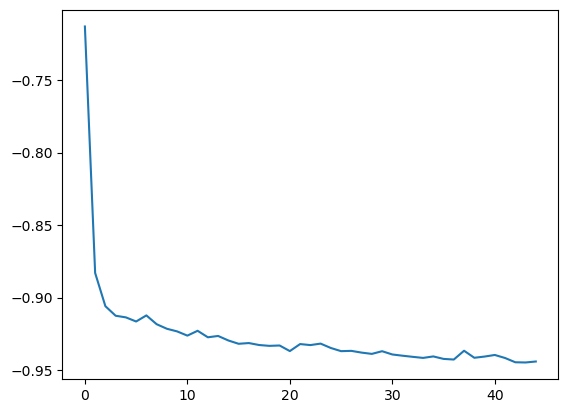

In [32]:
plt.plot(results2.history['loss'])

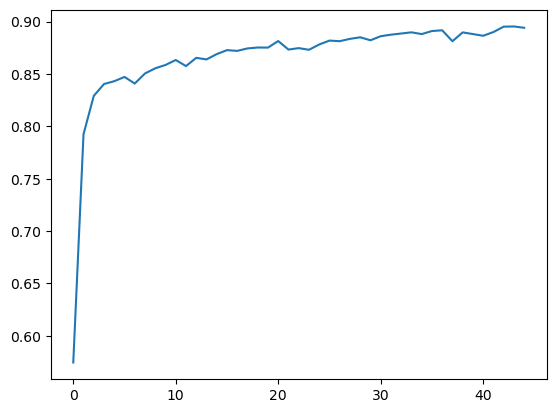

In [33]:
plt.plot(results2.history['iou'])

In [34]:
cb = TimingCallback()

UNet_3 = UNet((96, 96, 3), activation_= TrainableLeakyReLU())
model3 = UNet_3.buildModel()
UNet_3.CompileandSummarize(model3)
results3 = model3.fit(x = X_train, y = y_train, batch_size = 8, epochs=150, callbacks =  [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],  validation_data = (X_test, y_test))

training_inferences['TrainableLeakyReLU'] = sum(cb.logs)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_46 (Conv2D)             (None, 96, 96, 16)   449         ['input_3[0][0]']                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 96, 96, 16)   2321        ['conv2d_46[0][0]']              
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_47[0][0]']              
 )                                                                                          

2023-06-03 13:39:10.186233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 14s 33ms/step - loss: -0.4288 - iou: 0.2770 - val_loss: -0.3922 - val_iou: 0.2478
Epoch 2/150
67/67 [==============================] - 2s 24ms/step - loss: -0.4240 - iou: 0.2710 - val_loss: -0.3922 - val_iou: 0.2478
Epoch 3/150
67/67 [==============================] - 2s 24ms/step - loss: -0.4235 - iou: 0.2708 - val_loss: -0.3922 - val_iou: 0.2478
Epoch 4/150
67/67 [==============================] - 2s 26ms/step - loss: -0.4238 - iou: 0.2709 - val_loss: -0.3922 - val_iou: 0.2478
Epoch 5/150
67/67 [==============================] - 2s 24ms/step - loss: -0.4251 - iou: 0.2712 - val_loss: -0.3922 - val_iou: 0.2478
Epoch 6/150
67/67 [==============================] - 2s 24ms/step - loss: -0.4247 - iou: 0.2711 - val_loss: -0.3922 - val_iou: 0.2478
Epoch 7/150
67/67 [==============================] - 2s 25ms/step - loss: -0.4240 - iou: 0.2710 - val_loss: -0.3922 - val_iou: 0.2478
Epoch 8/150
67/67 [==============================] - 2s 24ms/step - loss:

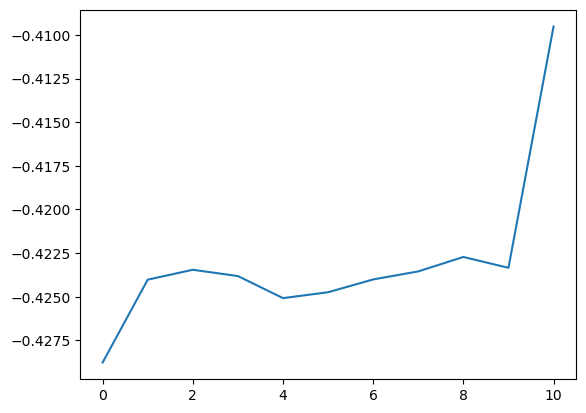

In [35]:
plt.plot(results3.history['loss'])

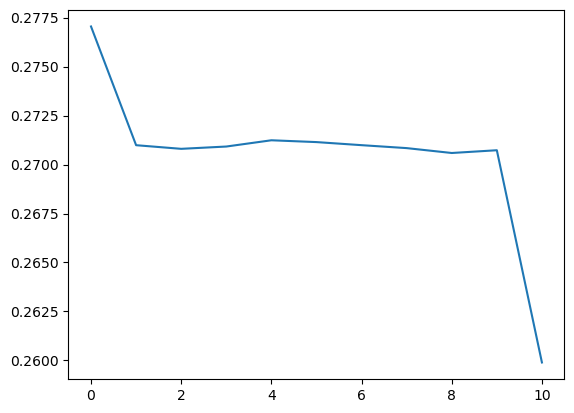

In [36]:
plt.plot(results3.history['iou'])

In [37]:
training_inferences

{'MexicanReLU': 104.73175273899983,
 'Swish': 82.12441393500058,
 'TrainableLeakyReLU': 30.381975676999673}

In [38]:
cb = TimingCallback()

UNet_4 = UNet((96, 96, 3), activation_= ISRU())
model4 = UNet_4.buildModel()
UNet_4.CompileandSummarize(model4)
results4 = model4.fit(x = X_train, y = y_train, batch_size = 8, epochs=150, callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['ISRU'] = sum(cb.logs)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_69 (Conv2D)             (None, 96, 96, 16)   449         ['input_4[0][0]']                
                                                                                                  
 conv2d_70 (Conv2D)             (None, 96, 96, 16)   2321        ['conv2d_69[0][0]']              
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_70[0][0]']              
 )                                                                                          

2023-06-03 13:39:58.833162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 15s 40ms/step - loss: -0.6893 - iou: 0.5432 - val_loss: -0.8411 - val_iou: 0.7280
Epoch 2/150
67/67 [==============================] - 2s 26ms/step - loss: -0.8437 - iou: 0.7314 - val_loss: -0.8678 - val_iou: 0.7685
Epoch 3/150
67/67 [==============================] - 2s 28ms/step - loss: -0.8742 - iou: 0.7782 - val_loss: -0.8859 - val_iou: 0.7969
Epoch 4/150
67/67 [==============================] - 2s 26ms/step - loss: -0.8867 - iou: 0.7985 - val_loss: -0.8970 - val_iou: 0.8145
Epoch 5/150
67/67 [==============================] - 2s 26ms/step - loss: -0.9022 - iou: 0.8224 - val_loss: -0.9044 - val_iou: 0.8271
Epoch 6/150
67/67 [==============================] - 2s 25ms/step - loss: -0.8987 - iou: 0.8172 - val_loss: -0.9030 - val_iou: 0.8250
Epoch 7/150
67/67 [==============================] - 2s 28ms/step - loss: -0.9017 - iou: 0.8222 - val_loss: -0.9091 - val_iou: 0.8344
Epoch 8/150
67/67 [==============================] - 2s 26ms/step - loss:

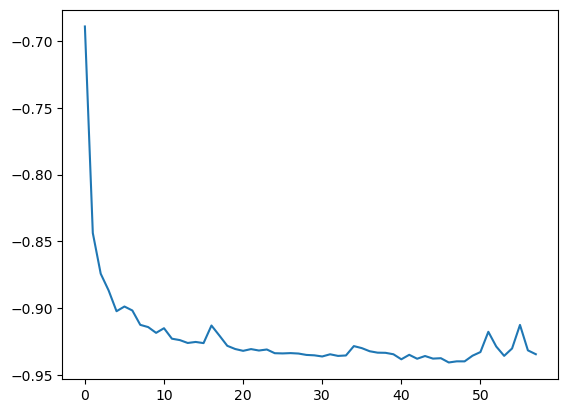

In [39]:
plt.plot(results4.history['loss'])

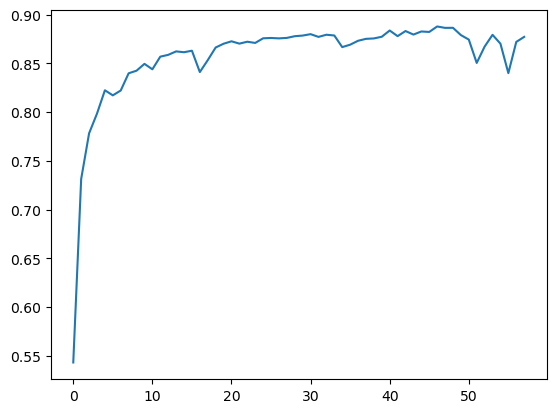

In [40]:
plt.plot(results4.history['iou'])

In [41]:
cb = TimingCallback()

UNet_5 = UNet((96, 96, 3), activation_= Mish())
model5 = UNet_5.buildModel()
UNet_5.CompileandSummarize(model5)
results5 = model5.fit(x = X_train, y = y_train, batch_size = 8, epochs=150,callbacks= [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['Mish'] = sum(cb.logs)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_92 (Conv2D)             (None, 96, 96, 16)   448         ['input_5[0][0]']                
                                                                                                  
 conv2d_93 (Conv2D)             (None, 96, 96, 16)   2320        ['conv2d_92[0][0]']              
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_93[0][0]']              
 )                                                                                          

2023-06-03 13:42:27.274715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 13s 32ms/step - loss: -0.4029 - iou: 0.2546 - val_loss: -0.3904 - val_iou: 0.2463
Epoch 2/150
67/67 [==============================] - 2s 23ms/step - loss: -0.4195 - iou: 0.2679 - val_loss: -0.3904 - val_iou: 0.2463
Epoch 3/150
67/67 [==============================] - 2s 23ms/step - loss: -0.4215 - iou: 0.2686 - val_loss: -0.3904 - val_iou: 0.2463
Epoch 4/150
67/67 [==============================] - 2s 26ms/step - loss: -0.4204 - iou: 0.2683 - val_loss: -0.3904 - val_iou: 0.2463
Epoch 5/150
67/67 [==============================] - 2s 31ms/step - loss: -0.4210 - iou: 0.2684 - val_loss: -0.3904 - val_iou: 0.2463
Epoch 6/150
67/67 [==============================] - 2s 24ms/step - loss: -0.4212 - iou: 0.2686 - val_loss: -0.3904 - val_iou: 0.2463
Epoch 7/150
67/67 [==============================] - 2s 24ms/step - loss: -0.4213 - iou: 0.2685 - val_loss: -0.3903 - val_iou: 0.2462
Epoch 8/150
67/67 [==============================] - 2s 24ms/step - loss:

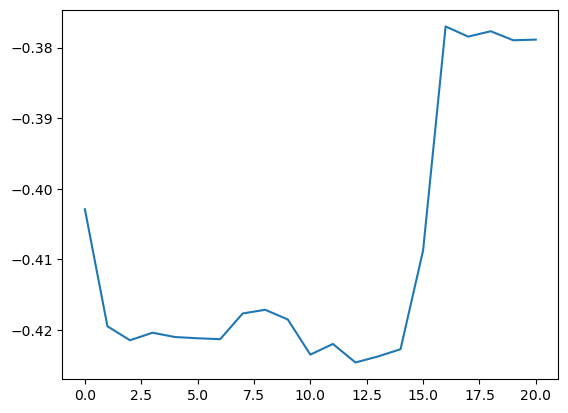

In [42]:
plt.plot(results5.history['loss'])

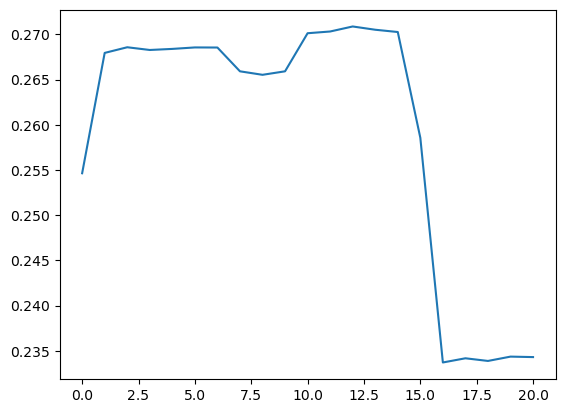

In [43]:
plt.plot(results5.history['iou'])

In [44]:
cb = TimingCallback()

UNet_6 = UNet((96, 96, 3), activation_= gated_swish())
model6 = UNet_6.buildModel()
UNet_6.CompileandSummarize(model6)
results6 = model6.fit(x = X_train, y = y_train, batch_size = 8, epochs=150, callbacks =  [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['gated_swish'] = sum(cb.logs)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_115 (Conv2D)            (None, 96, 96, 16)   448         ['input_6[0][0]']                
                                                                                                  
 conv2d_116 (Conv2D)            (None, 96, 96, 16)   2320        ['conv2d_115[0][0]']             
                                                                                                  
 max_pooling2d_25 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_116[0][0]']             
 )                                                                                          

2023-06-03 13:43:16.408349: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_50/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 14s 37ms/step - loss: -0.6108 - iou: 0.4562 - val_loss: -0.7238 - val_iou: 0.5776
Epoch 2/150
67/67 [==============================] - 2s 25ms/step - loss: -0.8556 - iou: 0.7525 - val_loss: -0.8808 - val_iou: 0.7889
Epoch 3/150
67/67 [==============================] - 2s 25ms/step - loss: -0.8975 - iou: 0.8172 - val_loss: -0.9001 - val_iou: 0.8197
Epoch 4/150
67/67 [==============================] - 2s 24ms/step - loss: -0.9066 - iou: 0.8313 - val_loss: -0.9034 - val_iou: 0.8253
Epoch 5/150
67/67 [==============================] - 2s 25ms/step - loss: -0.9108 - iou: 0.8382 - val_loss: -0.9121 - val_iou: 0.8395
Epoch 6/150
67/67 [==============================] - 2s 24ms/step - loss: -0.9102 - iou: 0.8377 - val_loss: -0.9016 - val_iou: 0.8220
Epoch 7/150
67/67 [==============================] - 2s 25ms/step - loss: -0.9169 - iou: 0.8488 - val_loss: -0.9100 - val_iou: 0.8361
Epoch 8/150
67/67 [==============================] - 2s 26ms/step - loss:

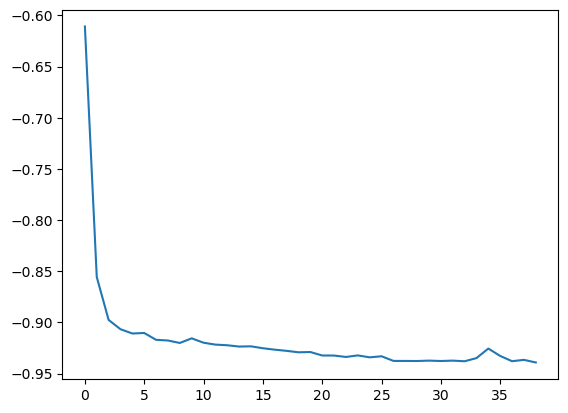

In [45]:
plt.plot(results6.history['loss'])

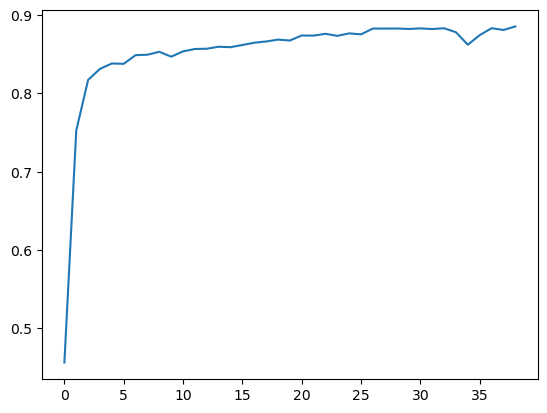

In [46]:
plt.plot(results6.history['iou'])

In [47]:
cb = TimingCallback()

UNet__ = UNet((96, 96, 3), activation_= "relu")
model_ = UNet__.buildModel()
UNet__.CompileandSummarize(model_)
results_ = model5.fit(x = X_train, y = y_train, batch_size = 8, epochs=150,callbacks = [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['relu'] = sum(cb.logs)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_138 (Conv2D)            (None, 96, 96, 16)   448         ['input_7[0][0]']                
                                                                                                  
 conv2d_139 (Conv2D)            (None, 96, 96, 16)   2320        ['conv2d_138[0][0]']             
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_139[0][0]']             
 )                                                                                          

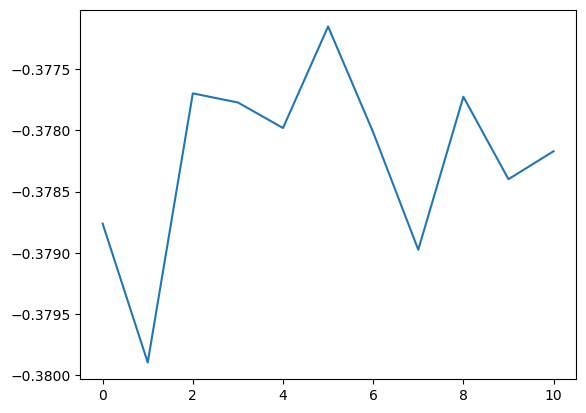

In [48]:
plt.plot(results_.history['loss'])

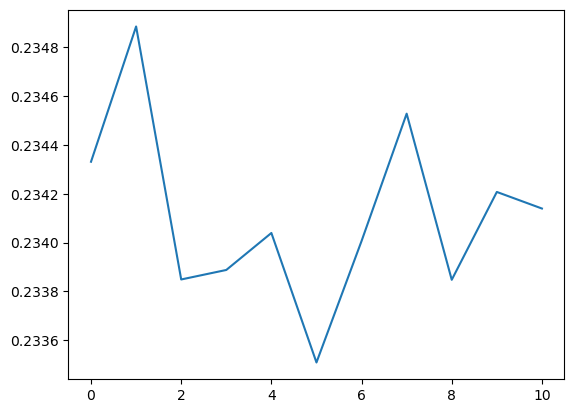

In [49]:
plt.plot(results_.history['iou'])

In [50]:
cb = TimingCallback()

UNet_ls = UNet((96, 96, 3), activation_= LearnableSwish())
modells = UNet_ls.buildModel()
UNet_ls.CompileandSummarize(modells)
resultsls = modells.fit(x = X_train, y = y_train, batch_size = 8, epochs=150, callbacks =  [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['LearnableSwish'] = sum(cb.logs)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_161 (Conv2D)            (None, 96, 96, 16)   449         ['input_8[0][0]']                
                                                                                                  
 conv2d_162 (Conv2D)            (None, 96, 96, 16)   2321        ['conv2d_161[0][0]']             
                                                                                                  
 max_pooling2d_35 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_162[0][0]']             
 )                                                                                          

2023-06-03 13:44:57.446355: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_70/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 13s 34ms/step - loss: -0.7015 - iou: 0.5650 - val_loss: -0.8589 - val_iou: 0.7553
Epoch 2/150
67/67 [==============================] - 2s 25ms/step - loss: -0.8651 - iou: 0.7659 - val_loss: -0.8878 - val_iou: 0.8002
Epoch 3/150
67/67 [==============================] - 2s 25ms/step - loss: -0.9046 - iou: 0.8275 - val_loss: -0.9014 - val_iou: 0.8217
Epoch 4/150
67/67 [==============================] - 2s 24ms/step - loss: -0.9093 - iou: 0.8349 - val_loss: -0.9028 - val_iou: 0.8241
Epoch 5/150
67/67 [==============================] - 2s 24ms/step - loss: -0.9129 - iou: 0.8412 - val_loss: -0.9146 - val_iou: 0.8438
Epoch 6/150
67/67 [==============================] - 2s 24ms/step - loss: -0.9168 - iou: 0.8477 - val_loss: -0.9129 - val_iou: 0.8408
Epoch 7/150
67/67 [==============================] - 2s 26ms/step - loss: -0.9168 - iou: 0.8480 - val_loss: -0.9129 - val_iou: 0.8409
Epoch 8/150
67/67 [==============================] - 2s 24ms/step - loss:

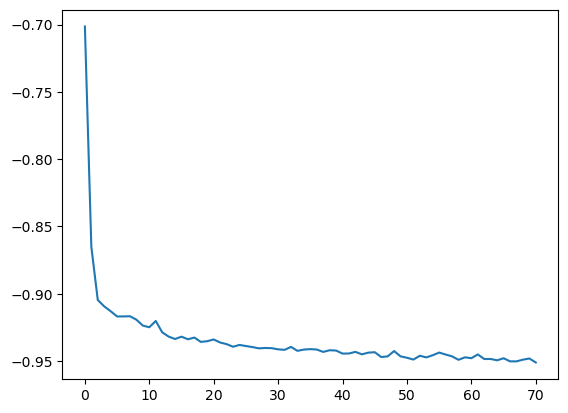

In [51]:
plt.plot(resultsls.history['loss'])

In [52]:
cb = TimingCallback()

UNet_srs = UNet((96, 96, 3), activation_= SRS())
modelsrs = UNet_srs.buildModel()
UNet_srs.CompileandSummarize(modelsrs)
resultsrs = modelsrs.fit(x = X_train, y = y_train, batch_size = 8, epochs=150, callbacks =  [cb, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], validation_data = (X_test, y_test))

training_inferences['SRS'] = sum(cb.logs)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_184 (Conv2D)            (None, 96, 96, 16)   448         ['input_9[0][0]']                
                                                                                                  
 conv2d_185 (Conv2D)            (None, 96, 96, 16)   2320        ['conv2d_184[0][0]']             
                                                                                                  
 max_pooling2d_40 (MaxPooling2D  (None, 48, 48, 16)  0           ['conv2d_185[0][0]']             
 )                                                                                          

2023-06-03 13:47:27.103486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_80/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 14s 32ms/step - loss: -0.7555 - iou: 0.6260 - val_loss: -0.8104 - val_iou: 0.6880
Epoch 2/150
67/67 [==============================] - 2s 24ms/step - loss: -0.8859 - iou: 0.7965 - val_loss: -0.8916 - val_iou: 0.8059
Epoch 3/150
67/67 [==============================] - 2s 26ms/step - loss: -0.9053 - iou: 0.8282 - val_loss: -0.9093 - val_iou: 0.8348
Epoch 4/150
67/67 [==============================] - 2s 24ms/step - loss: -0.9127 - iou: 0.8403 - val_loss: -0.9120 - val_iou: 0.8395
Epoch 5/150
67/67 [==============================] - 2s 24ms/step - loss: -0.9156 - iou: 0.8453 - val_loss: -0.8636 - val_iou: 0.7646
Epoch 6/150
67/67 [==============================] - 2s 24ms/step - loss: -0.9159 - iou: 0.8456 - val_loss: -0.9182 - val_iou: 0.8497
Epoch 7/150
67/67 [==============================] - 2s 25ms/step - loss: -0.9133 - iou: 0.8412 - val_loss: -0.9128 - val_iou: 0.8406
Epoch 8/150
67/67 [==============================] - 2s 25ms/step - loss:

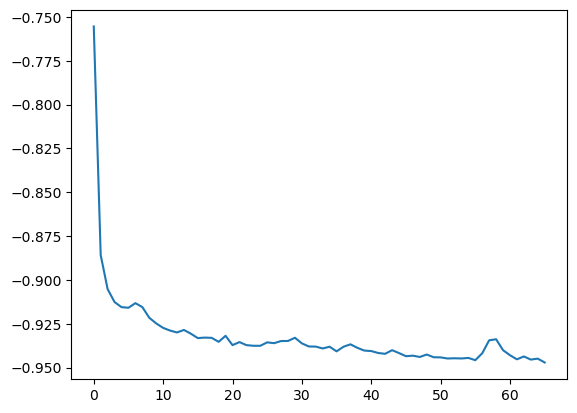

In [53]:
plt.plot(resultsrs.history['loss'])

In [54]:
x = []
y = []

for i in training_inferences:
    x.append(i)
    y.append(training_inferences[i])

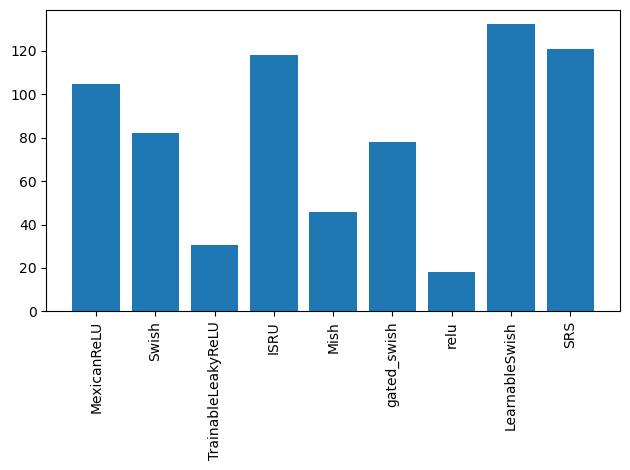

In [55]:
fig, ax = plt.subplots()
plt.bar(range(len(y)), y, tick_label=x)
plt.xticks(rotation='vertical')
fig.tight_layout()
plt.show()

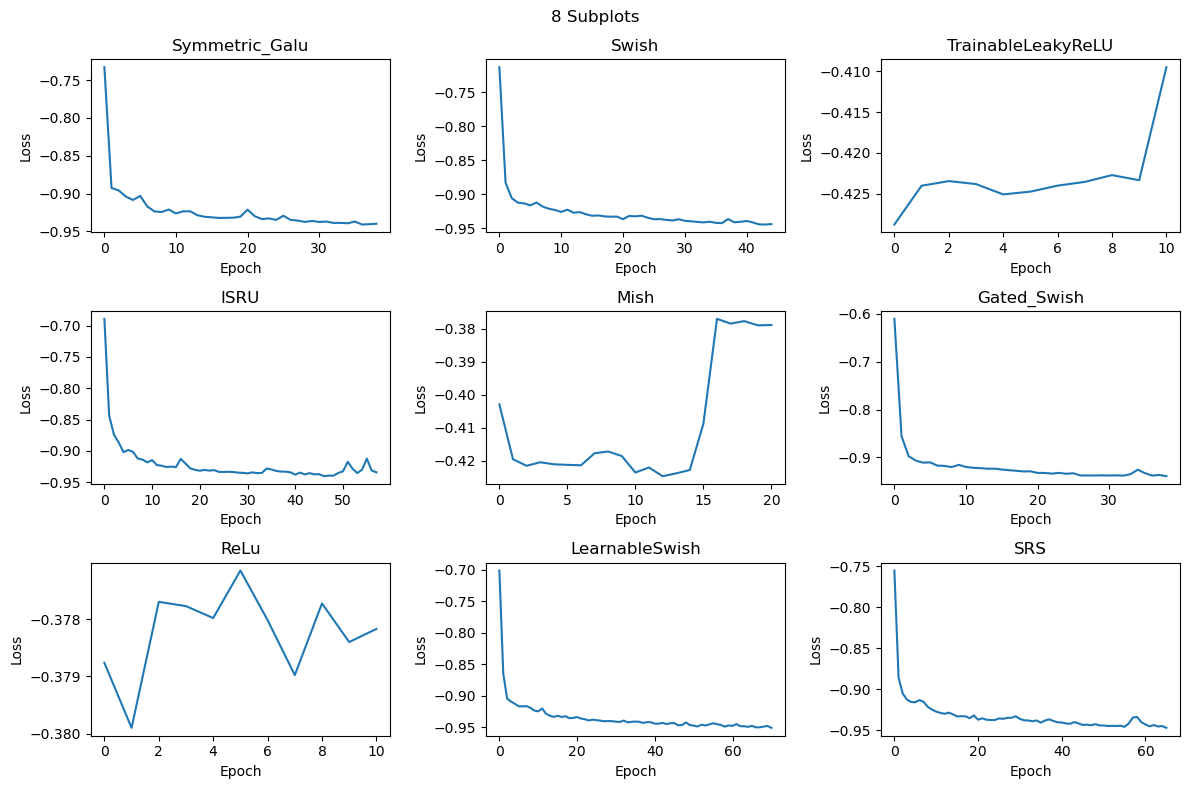

In [56]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure with 2 rows and 4 columns of subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

# Plot the data on the subplots
axs[0, 0].plot(results1.history['loss'])
axs[0, 1].plot(results2.history['loss'])
axs[0, 2].plot(results3.history['loss'])
axs[1, 0].plot(results4.history['loss'])
axs[1, 1].plot(results5.history['loss'])
axs[1, 2].plot(results6.history['loss'])
axs[2, 0].plot(results_.history['loss'])
axs[2, 1].plot(resultsls.history['loss'])
axs[2,2].plot(resultsrs.history['loss'])

# Add titles to the subplots
axs[0, 0].set_title('Symmetric_Galu')
axs[0, 1].set_title('Swish')
axs[0, 2].set_title('TrainableLeakyReLU')
axs[1, 0].set_title('ISRU')
axs[1, 1].set_title('Mish')
axs[1, 2].set_title('Gated_Swish')
axs[2, 0].set_title('ReLu')
axs[2, 1].set_title('LearnableSwish')
axs[2, 2].set_title('SRS')

# Add x and y axis labels
for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

# Add a main title to the figure
fig.suptitle('8 Subplots')

# Adjust the spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()


In [57]:
batch_size = X_test.shape[0]  # Get the batch size
height, width, channels = 96, 96, 3  # Set the height, width, and channels

# Reshape the input tensor to match the expected shape
X_test_reshaped = np.reshape(X_test, (batch_size, height, width, channels))

5/5 [==============================] - 1s 15ms/step


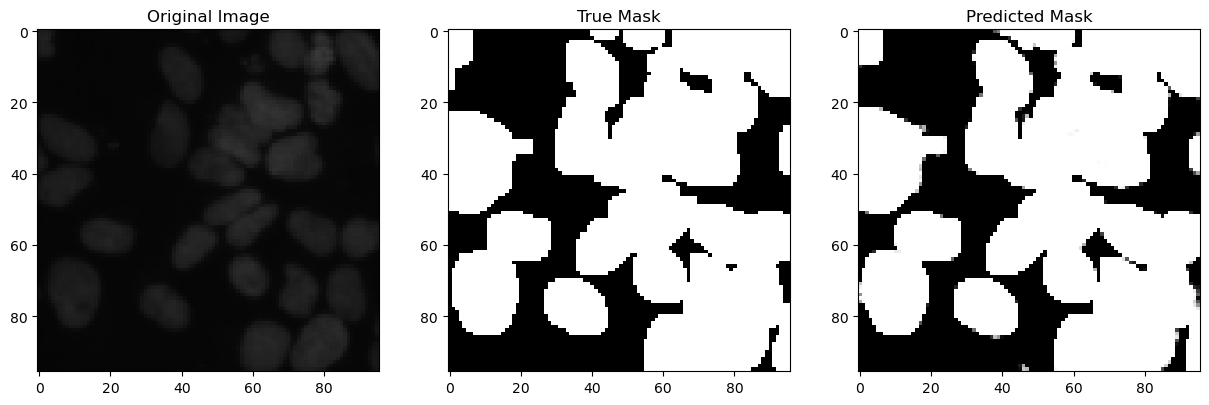

In [58]:

#Mexican_Relu
y_pred = model1.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred, axis=1)
import matplotlib.pyplot as plt

# Assuming you have already made predictions on your test data and you have the predicted masks in a variable y_pred

# Choose a random image from the test set to plot
index = 10 # Change this to the index of the image you want to plot
image = X_test[index]  # Get the original image data
mask_true = y_test[index]  # Get the true mask for the image
mask_pred = y_pred[index]  # Get the predicted mask for the image

# Create a subplot with three columns to plot the original image, true mask and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Plot the true mask in the second column
ax[1].imshow(mask_true, cmap='gray')
ax[1].set_title("True Mask")

# Plot the predicted mask in the third column
ax[2].imshow(mask_pred, cmap='gray')
ax[2].set_title("Predicted Mask")

# Show the plot
plt.show()

5/5 [==============================] - 0s 11ms/step


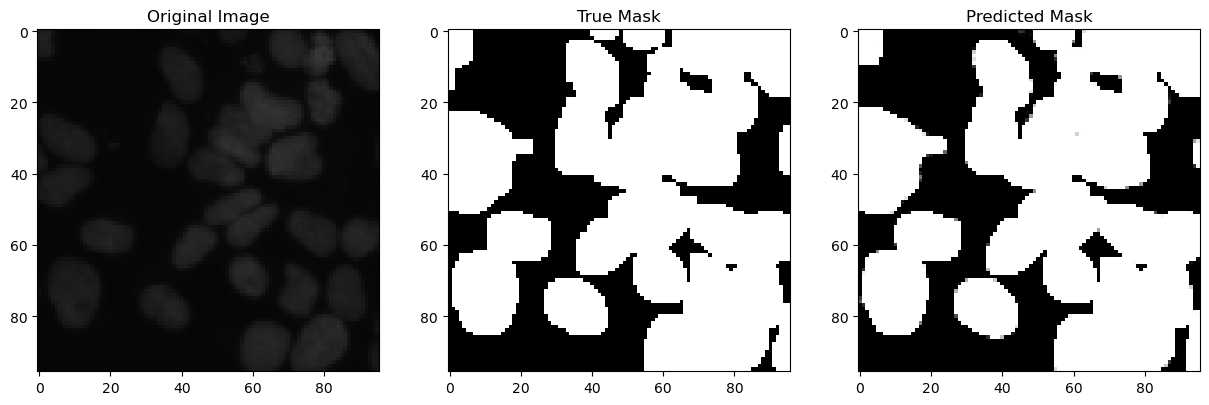

In [59]:
#Swish
y_pred2=model2.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred2, axis=1)
# Assuming you have already made predictions on your test data and you have the predicted masks in a variable y_pred

# Choose a random image from the test set to plot
index = 10  # Change this to the index of the image you want to plot
image = X_test[index]  # Get the original image data
mask_true = y_test[index]  # Get the true mask for the image
mask_pred = y_pred2[index]  # Get the predicted mask for the image

# Create a subplot with three columns to plot the original image, true mask and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Plot the true mask in the second column
ax[1].imshow(mask_true, cmap='gray')
ax[1].set_title("True Mask")

# Plot the predicted mask in the third column
ax[2].imshow(mask_pred, cmap='gray')
ax[2].set_title("Predicted Mask")

# Show the plot
plt.show()

5/5 [==============================] - 0s 11ms/step


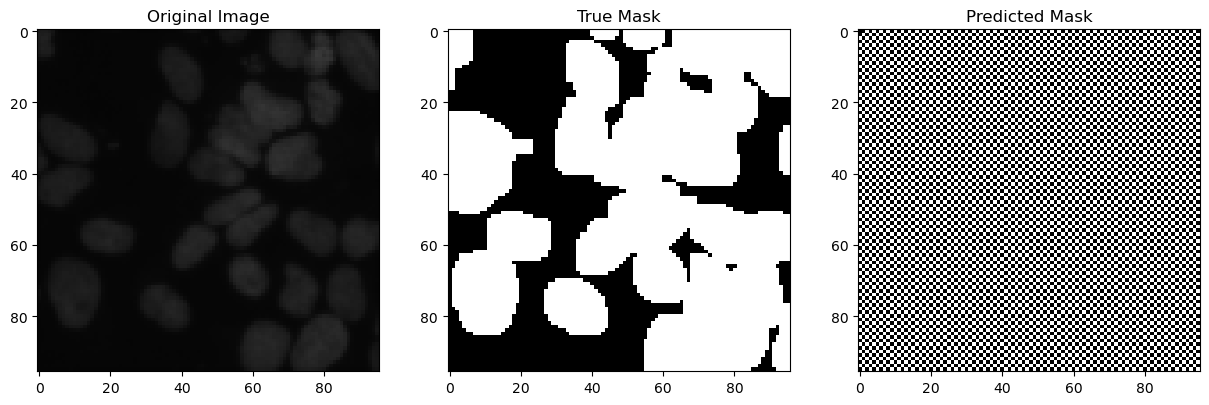

In [60]:
#TrainableLekyRelu
y_pred3=model3.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred3, axis=1)
# Assuming you have already made predictions on your test data and you have the predicted masks in a variable y_pred

# Choose a random image from the test set to plot
index = 10  # Change this to the index of the image you want to plot
image = X_test[index]  # Get the original image data
mask_true = y_test[index]  # Get the true mask for the image
mask_pred = y_pred3[index]  # Get the predicted mask for the image

# Create a subplot with three columns to plot the original image, true mask and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Plot the true mask in the second column
ax[1].imshow(mask_true, cmap='gray')
ax[1].set_title("True Mask")

# Plot the predicted mask in the third column
ax[2].imshow(mask_pred, cmap='gray')
ax[2].set_title("Predicted Mask")

# Show the plot
plt.show()

5/5 [==============================] - 1s 12ms/step


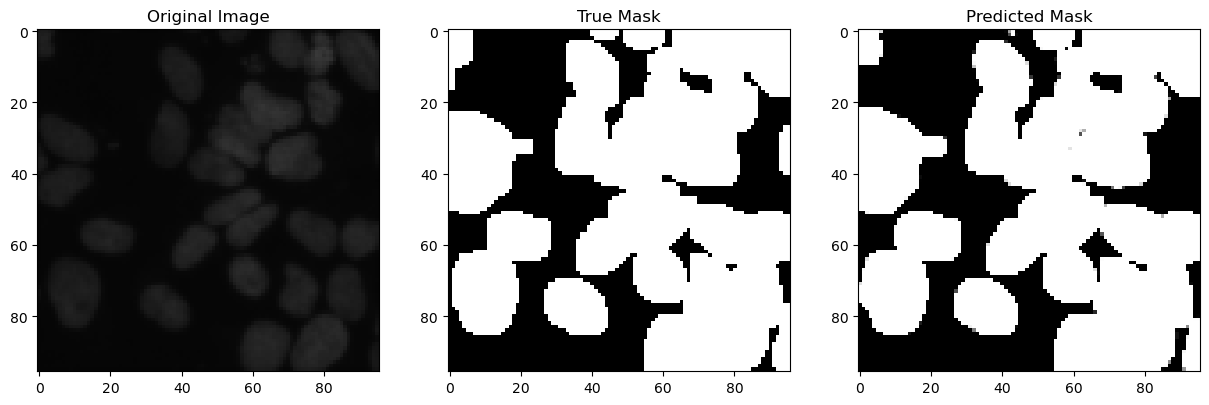

In [61]:
#ISRU
y_pred4=model4.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred4, axis=1)
# Assuming you have already made predictions on your test data and you have the predicted masks in a variable y_pred

# Choose a random image from the test set to plot
index = 10  # Change this to the index of the image you want to plot
image = X_test[index]  # Get the original image data
mask_true = y_test[index]  # Get the true mask for the image
mask_pred = y_pred4[index]  # Get the predicted mask for the image

# Create a subplot with three columns to plot the original image, true mask and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Plot the true mask in the second column
ax[1].imshow(mask_true, cmap='gray')
ax[1].set_title("True Mask")

# Plot the predicted mask in the third column
ax[2].imshow(mask_pred, cmap='gray')
ax[2].set_title("Predicted Mask")

# Show the plot
plt.show()

5/5 [==============================] - 0s 11ms/step


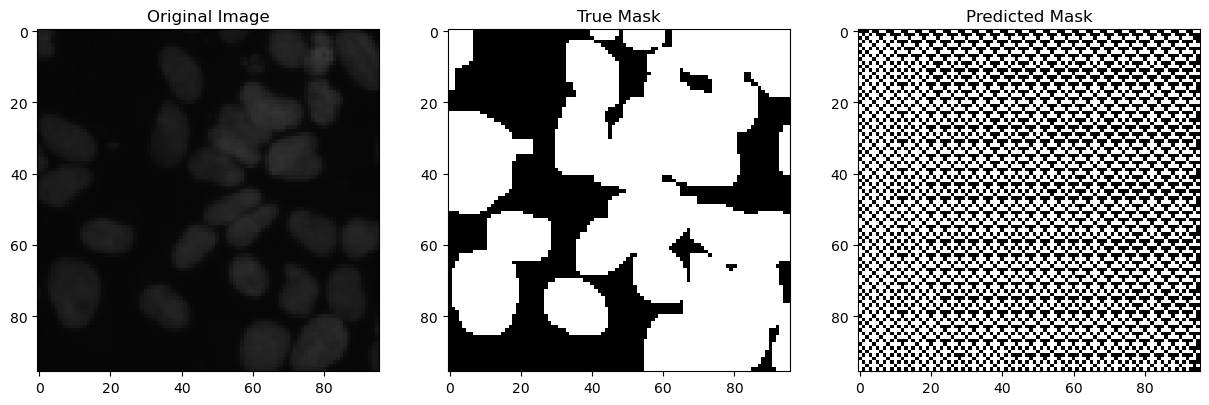

In [62]:
#Mish
y_pred5=model5.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred5, axis=1)
# Assuming you have already made predictions on your test data and you have the predicted masks in a variable y_pred

# Choose a random image from the test set to plot
index = 10  # Change this to the index of the image you want to plot
image = X_test[index]  # Get the original image data
mask_true = y_test[index]  # Get the true mask for the image
mask_pred = y_pred5[index]  # Get the predicted mask for the image

# Create a subplot with three columns to plot the original image, true mask and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Plot the true mask in the second column
ax[1].imshow(mask_true, cmap='gray')
ax[1].set_title("True Mask")

# Plot the predicted mask in the third column
ax[2].imshow(mask_pred, cmap='gray')
ax[2].set_title("Predicted Mask")

# Show the plot
plt.show()

5/5 [==============================] - 1s 12ms/step


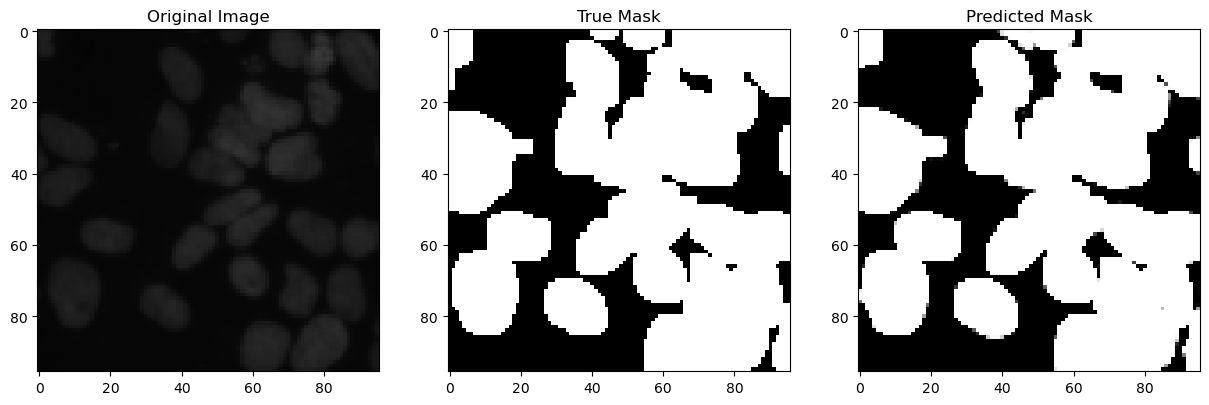

In [63]:
#Gated Swish
y_pred6=model6.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred6, axis=1)
# Choose a random image from the test set to plot
index = 10  # Change this to the index of the image you want to plot
image = X_test[index]  # Get the original image data
mask_true = y_test[index]  # Get the true mask for the image
mask_pred = y_pred6[index]  # Get the predicted mask for the image

# Create a subplot with three columns to plot the original image, true mask and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Plot the true mask in the second column
ax[1].imshow(mask_true, cmap='gray')
ax[1].set_title("True Mask")

# Plot the predicted mask in the third column
ax[2].imshow(mask_pred, cmap='gray')
ax[2].set_title("Predicted Mask")

# Show the plot
plt.show()

5/5 [==============================] - 1s 39ms/step


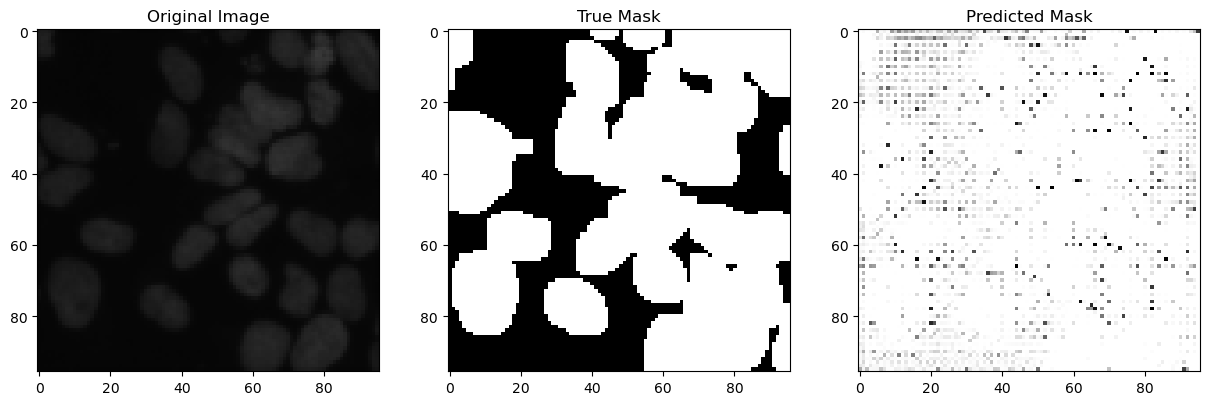

In [64]:
#relu
y_pred7=model_.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred7, axis=1)
# Choose a random image from the test set to plot
index = 10  # Change this to the index of the image you want to plot
image = X_test[index]  # Get the original image data
mask_true = y_test[index]  # Get the true mask for the image
mask_pred = y_pred7[index]  # Get the predicted mask for the image

# Create a subplot with three columns to plot the original image, true mask and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Plot the true mask in the second column
ax[1].imshow(mask_true, cmap='gray')
ax[1].set_title("True Mask")

# Plot the predicted mask in the third column
ax[2].imshow(mask_pred, cmap='gray')
ax[2].set_title("Predicted Mask")

# Show the plot
plt.show()

5/5 [==============================] - 1s 11ms/step


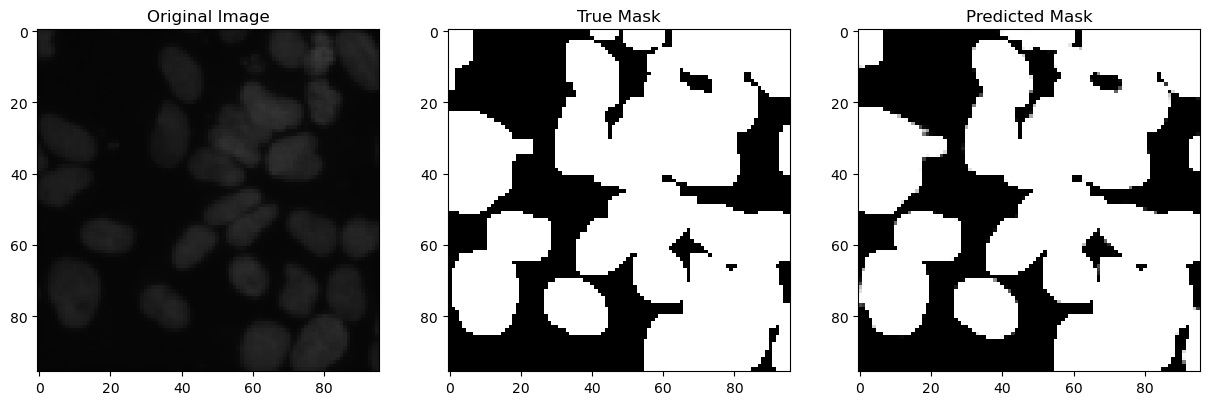

In [65]:
#Learnable Swish
y_pred8=modells.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred8, axis=1)
# Choose a random image from the test set to plot
index = 10  # Change this to the index of the image you want to plot
image = X_test[index]  # Get the original image data
mask_true = y_test[index]  # Get the true mask for the image
mask_pred = y_pred8[index]  # Get the predicted mask for the image

# Create a subplot with three columns to plot the original image, true mask and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Plot the true mask in the second column
ax[1].imshow(mask_true, cmap='gray')
ax[1].set_title("True Mask")

# Plot the predicted mask in the third column
ax[2].imshow(mask_pred, cmap='gray')
ax[2].set_title("Predicted Mask")

# Show the plot
plt.show()

5/5 [==============================] - 1s 11ms/step


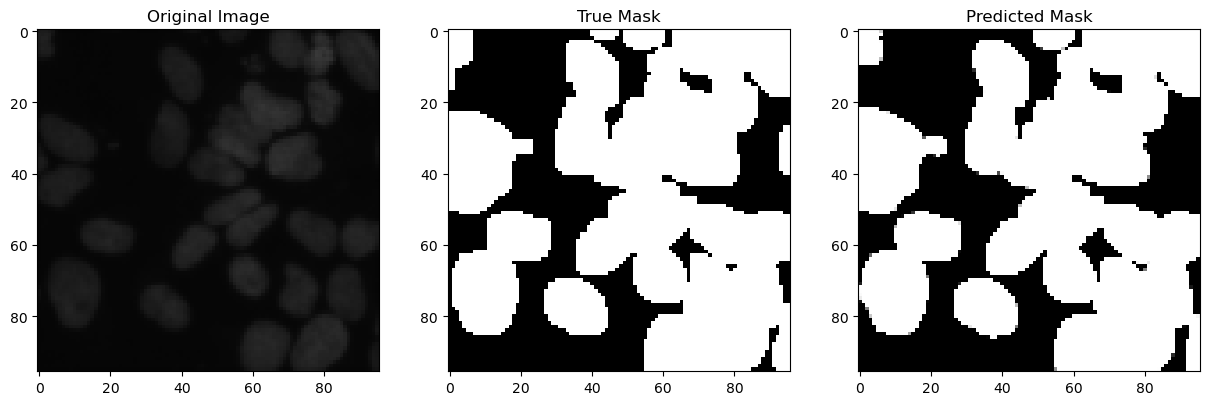

In [66]:
#SRS
y_pred9=modelsrs.predict(X_test_reshaped)
predicted_classes = np.argmax(y_pred9, axis=1)
# Choose a random image from the test set to plot
index = 10  # Change this to the index of the image you want to plot
image = X_test[index]  # Get the original image data
mask_true = y_test[index]  # Get the true mask for the image
mask_pred = y_pred9[index]  # Get the predicted mask for the image

# Create a subplot with three columns to plot the original image, true mask and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image in the first column
ax[0].imshow(image)
ax[0].set_title("Original Image")

# Plot the true mask in the second column
ax[1].imshow(mask_true, cmap='gray')
ax[1].set_title("True Mask")

# Plot the predicted mask in the third column
ax[2].imshow(mask_pred, cmap='gray')
ax[2].set_title("Predicted Mask")

# Show the plot
plt.show()